In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import torch
import torch.nn as nn
from torch.nn import functional as F
from itertools import groupby
from operator import itemgetter
import datetime
import math
import pandas as pd
import numpy as np
import pytz

file1 = "all_training_data_sorted.csv"
north = 'data_north_p.csv'
east = 'data_east_p.csv'
south = 'data_south_p.csv'
west = 'data_west_p.csv'
device = 'cuda'

tz = pytz.timezone('Europe/Berlin')

def convert_to_weeknumber_cossin(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    dt_local = date.astimezone(tz)
    week_number = dt_local.isocalendar()[1]
    sin_week = np.sin(2*np.pi*week_number/53).astype(np.float32)
    cos_week = np.cos(2*np.pi*week_number/53).astype(np.float32)
    return sin_week, cos_week

def convert_to_hour_cossin(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    dt_local = date.astimezone(tz)
    hour = dt_local.hour
    sin_hour = np.sin(2*np.pi*hour/24).astype(np.float32)
    cos_hour = np.cos(2*np.pi*hour/24).astype(np.float32)
    return sin_hour, cos_hour


def closest_timestamp(data, timestamp):
    closest_timestamp = min(data.keys(), key=lambda t: abs(t - timestamp))
    return data[closest_timestamp]

def read_csv(file):
    data = pd.read_csv(file)
    for index, row in data.iterrows():
        yield row['time'] / 1_000_000_000, row['tags'], row['min'], row['max'], row['mean'] 

def read_csv_meteostat(file):
    data = pd.read_csv(file)
    timestamp_dict = {}
    for index, row in data.iterrows():
        if not pd.isna(row['time']) and not pd.isna(row['pres']):
            timestamp = row['time'] / 1_000_000_000
            timestamp_dict[timestamp] = row['pres']                            
    return timestamp_dict

def group_column(file, north, east, south, west):
    meteostat_data_north = read_csv_meteostat(north)
    meteostat_data_east = read_csv_meteostat(east)
    meteostat_data_south = read_csv_meteostat(south)
    meteostat_data_west = read_csv_meteostat(west)
    
    for timestamp, values in groupby(read_csv(file), key=itemgetter(0)):
        pres_value_north = closest_timestamp(meteostat_data_north, timestamp)
        pres_value_east = closest_timestamp(meteostat_data_east, timestamp)
        pres_value_south = closest_timestamp(meteostat_data_south, timestamp)
        pres_value_west = closest_timestamp(meteostat_data_west, timestamp)
        
        d = {}
        for (_, topic, value_min, value_max, value_mean) in values:
            if not math.isnan(value_min) and not math.isnan(value_max) and not math.isnan(value_mean):
                d[topic] = {'min': value_min, 'max': value_max, 'mean': value_mean}
        
        try:
            week_values = convert_to_weeknumber_cossin(timestamp)
            hour_values = convert_to_hour_cossin(timestamp)
            yield (
                (d["topic=Pfullingen/temperature"]['mean'] - 20) / 35, 
                (d["topic=Pfullingen/hourlyrain"]['mean']) / 10, 
                (d["topic=Pfullingen/windspeed"]['mean']- 5) / 10,
                (d["topic=Pfullingen/solarradiation"]['max'] - 500) / 1000,
                (d["topic=Pfullingen/solarradiation"]['mean'] - 500) / 1000, 
                (d["topic=Pfullingen/pressure"]['mean'] - 500) / 1000,
                (d["topic=Pfullingen/winddir"]['mean'] - 180) / 360,
                (d["topic=Pfullingen/humidity"]['mean'] - 50) / 100,
                hour_values[0],
                hour_values[1],
                week_values[0],
                week_values[1],
                float((pres_value_north - 500) / 1000),
                float((pres_value_east - 500) / 1000),
                float((pres_value_south - 500) / 1000),
                float((pres_value_west - 500) / 1000)
                
            )
        except KeyError:
            pass



In [22]:
imported_data_raw = list(group_column(file1, north, east, south, west))
imported_data = torch.tensor(imported_data_raw)
imported_data.shape

torch.Size([18664, 16])

In [23]:
imported_data[:5]

tensor([[-5.6225e-01,  0.0000e+00, -4.5033e-01, -4.9046e-01, -4.9588e-01,
          5.2175e-01, -9.5078e-02,  1.2356e-01,  1.0000e+00,  6.1232e-17,
          9.6464e-01,  2.6359e-01,  5.1670e-01,  5.2310e-01,  5.1890e-01,
          5.2400e-01],
        [-5.5140e-01,  0.0000e+00, -4.6132e-01, -4.6147e-01, -4.7288e-01,
          5.2159e-01, -1.3631e-01,  9.7692e-02,  9.6593e-01, -2.5882e-01,
          9.6464e-01,  2.6359e-01,  5.1690e-01,  5.2280e-01,  5.1890e-01,
          5.2400e-01],
        [-5.3241e-01,  0.0000e+00, -3.7868e-01, -4.5107e-01, -4.6345e-01,
          5.2132e-01,  4.5037e-02,  2.3951e-02,  8.6603e-01, -5.0000e-01,
          9.6464e-01,  2.6359e-01,  5.1720e-01,  5.2230e-01,  5.1890e-01,
          5.2500e-01],
        [-5.2361e-01,  0.0000e+00, -2.9481e-01, -4.4752e-01, -4.5164e-01,
          5.2123e-01,  1.3667e-01,  1.6364e-02,  7.0711e-01, -7.0711e-01,
          9.6464e-01,  2.6359e-01,  5.1760e-01,  5.2180e-01,  5.1880e-01,
          5.2400e-01],
        [-5.0978e-01

In [9]:
import math
import torch
import torch.nn as nn
import torch.optim as optim

def generate_square_subsequent_mask(sz):
    mask = torch.tril(torch.ones(sz, sz))
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super().__init__()
        self.d_model = d_model

        # Create constant 'pe' matrix with values dependant on pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                
                if i + 1 < d_model:
                    pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                    
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # Make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        # Add constant to embedding
        seq_len = x.size(1)
        x = x + self.pe[:,:seq_len]
        return x

class TransformerBlock(nn.Module):
    def __init__(self, k, heads):
        super().__init__()

        self.attention = nn.MultiheadAttention(k, heads)
        self.norm1 = nn.LayerNorm(k)
        self.norm2 = nn.LayerNorm(k)

        self.ff = nn.Sequential(
            nn.Linear(k, 4 * k),
            nn.ReLU(),
            nn.Linear(4 * k, k)
        )

    def forward(self, value, key, query, mask=None):
        if mask is not None:
            att = self.attention(query, key, value, attn_mask=mask)[0]
        else:
            att = self.attention(query, key, value)[0]
        x = self.norm1(att + value)
        ff = self.ff(x)
        return self.norm2(ff + x)

class Predictor(nn.Module):
    def __init__(self, k, heads, depth, seq_length, num_features, max_seq_len=80):
        super().__init__()
        self.k = k
        self.num_features = num_features
        self.seq_length = seq_length

        self.pos_encoder = PositionalEncoder(k, max_seq_len)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(k, heads) for _ in range(depth)
        ])

        self.linear = nn.Linear(k, num_features)

    def forward(self, x):
        # x has shape (batch_size, seq_length, num_features)
        x = x.permute(1, 0, 2)  # (seq_length, batch_size, num_features)
        x = self.pos_encoder(x)  # Add positional encodings

        mask = generate_square_subsequent_mask(x.size(0)).to(x.device)

        # Apply the transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer(x, x, x, mask)

        x = self.linear(x.permute(1, 0, 2).reshape(-1, self.k))

        return x.reshape(-1, self.seq_length, self.num_features)

k = 16  # Dimension of transformer key/query/value vectors 10
heads = 16  # Number of attention heads 2
depth = 12 # Number of transformer blocks 2
num_features = 16  # Number of input features (temperature, pressure)
seq_length = 72  # Length of the sequence
model = Predictor(k, heads, depth, seq_length, num_features)



In [1]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(data.size(0)-seq_length*2):
        x = data[i:(i+seq_length)]
        y = data[(i+seq_length):(i+seq_length*2)]
        xs.append(x)
        ys.append(y)

    return torch.stack(xs), torch.stack(ys)



In [3]:
X, y = create_sequences(imported_data, seq_length)
print(X.shape)
print(y.shape)

NameError: name 'imported_data' is not defined

In [27]:
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader

# Calculate split sizes
num_samples = len(X)
num_train = round(num_samples * 0.8)
num_val = num_samples - num_train

# Create data sets
train_data, val_data = random_split(TensorDataset(X, y), [num_train, num_val])

batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [10]:
model = Predictor(k, heads, depth, seq_length, num_features, max_seq_len=80).to(device)

In [11]:
model.load_state_dict(torch.load('weather_pfullingen.pth'))

<All keys matched successfully>

In [33]:
# Training Loop
num_epochs = 1
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Get model predictions for the inputs

        # Compute the loss
        # Compute the loss
        # loss = weighted_temporal_loss(outputs[:,:24,:], labels[:,:24,:], feature_weights)
        loss = criterion(outputs[:,:24,:], labels[:,:24,:])
        #loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
       

    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_losses = []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, num_epochs, avg_val_loss))
#best was 0.0030

Epoch [1/1], Train Loss: 0.0049
Epoch [1/1], Validation Loss: 0.0034


In [12]:
file1_forecast = "test_sorted.csv"
north_forecast = 'data_north_p_test_latest.csv'
east_forecast = 'data_east_p_test_latest.csv'
south_forecast = 'data_south_p_test_latest.csv'
west_forecast = 'data_west_p_test_latest.csv'

In [20]:
file1_forecast = "test_before_coldfront_sorted.csv"
north_forecast = 'data_north_p_test_latest_before_coldfront.csv'
east_forecast = 'data_east_p_test_latest_before_coldfront.csv'
south_forecast = 'data_south_p_test_latest_before_coldfront.csv'
west_forecast = 'data_west_p_test_latest_before_coldfront.csv'

In [21]:
model.eval()
imported_data_raw = list(group_column(file1_forecast, north_forecast, east_forecast, south_forecast, west_forecast))
imported_data = torch.tensor(imported_data_raw, device=device)
eval_data = imported_data[-seq_length:]
eval_data = eval_data.view(1,seq_length,num_features)
output = model(eval_data)
model.train()

Predictor(
  (pos_encoder): PositionalEncoder()
  (transformer_blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=16, bias=True)
      )
    )
  )
  (linear): Linear(in_features=16, out_features=16, bias=True)
)

In [22]:
temperature = output[0, :, 0]*35+20
sol_max =     output[0, :, 3]*1000+500
sol_mean =    output[0, :, 4]*1000+500
wind =        output[0, :, 2]*10+5
rain =        output[0, :, 2]*10
press =       output[0, :, 5]*1000+500
winddir =     output[0, :, 6]*360+180
humidty =     output[0, :, 7]*100+50
hourv =       output[0, :, 8]
# Convert tensors to numpy arrays for plotting
temperature = temperature.cpu().detach().numpy()
sol_max = sol_max.cpu().detach().numpy()
sol_mean = sol_mean.cpu().detach().numpy()
wind = wind.cpu().detach().numpy()
rain = rain.cpu().detach().numpy()
hourv = hourv.cpu().detach().numpy()
press = press.cpu().detach().numpy()
winddir = winddir.cpu().detach().numpy()
humidty = humidty.cpu().detach().numpy()

Text(0, 0.5, 'Temperature')

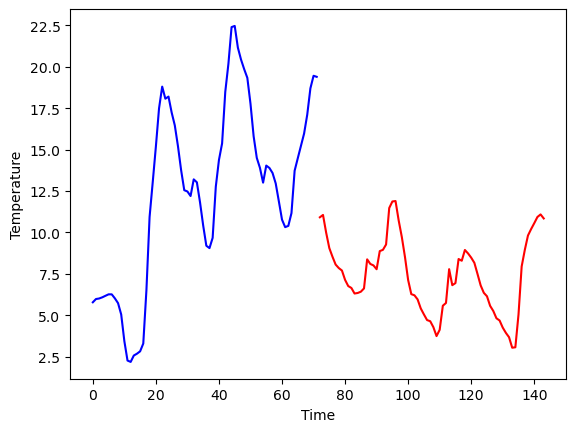

In [23]:
input_temperature = eval_data.view(72,16)[:,0]*35+20
temperature = output[0, :, 0]*35+20
forecast_temperature = temperature.cpu().detach().numpy()
input_temperature = input_temperature.cpu().detach().numpy()

import matplotlib.pyplot as plt
# Generate x-axis values for the plots
x_input = range(len(input_temperature))
x_forecast = range(len(input_temperature), len(input_temperature) + len(forecast_temperature))

# Plot input_temperature in blue
plt.plot(x_input, input_temperature, color='blue', label='Input Temperature')

# Plot forecast_temperature in red
plt.plot(x_forecast, forecast_temperature, color='red', label='Forecast Temperature')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Temperature')

In [128]:
torch.save(model.state_dict(), 'weather_pfullingen_temp.pth')

In [25]:
temperature = output[0, :, 0]*35+20
sol_max =     output[0, :, 3]*1000+500
sol_mean =    output[0, :, 4]*1000+500
wind =        output[0, :, 2]*10+5
for i, temp in enumerate(temperature):
    print(i, temp.item())

0 24.25092315673828
1 22.14498519897461
2 23.33417320251465
3 19.920251846313477
4 20.249547958374023
5 24.490070343017578
6 24.185962677001953
7 24.53146743774414
8 22.39141273498535
9 20.180889129638672
10 19.60460662841797
11 17.763294219970703
12 16.120222091674805
13 16.321491241455078
14 16.064865112304688
15 16.588191986083984
16 15.731671333312988
17 14.73770523071289
18 13.983736991882324
19 13.898340225219727
20 17.344844818115234
21 18.97541618347168
22 20.77316665649414
23 21.36025619506836
24 20.449228286743164
25 21.194623947143555
26 21.495031356811523
27 25.01914405822754
28 25.424924850463867
29 25.993789672851562
30 25.610788345336914
31 24.119897842407227
32 22.87637710571289
33 21.664825439453125
34 20.328031539916992
35 19.29500961303711
36 17.729455947875977
37 17.700695037841797
38 15.965675354003906
39 15.0931396484375
40 14.52330207824707
41 13.931970596313477
42 13.765626907348633
43 14.426069259643555
44 15.45541000366211
45 17.297094345092773
46 18.751131057